In [43]:
import numpy as np
import matplotlib.pyplot as plt
from rayleighsommerfeld import rayleighsommerfeld
import trackpy as tp
from itertools import chain
from matplotlib import colors
import pickle
from time import process_time

In [44]:
def show_small(im, axis_state):
    fig, ax = plt.subplots(figsize = (3,3))
    ax.imshow(im, cmap = 'gray')
    ax.axis(axis_state)

#### load image and crop

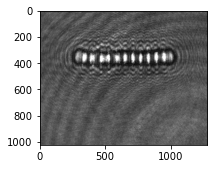

In [45]:
parent = './norm_images_12-mer_600/'
num_monomers = 12
date = '060922'
image = 'image0000'
h = 600
fg = plt.imread(parent+image+'.png')
show_small(fg, 'on')

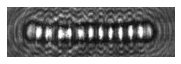

In [46]:
xmin, ymin = 150, 200
dx, dy = 1000, 300
fg_cropped = fg[ymin:ymin+dy, xmin:xmin+dx]
show_small(fg_cropped, 'off')

#### rayleigh-sommerfeld propagation

In [47]:
t1_start = process_time() 

zmin = -20.
zmax = 0.
n = 200
mpp = .048

z = np.linspace(zmin, zmax, n)/mpp

a = fg_cropped
res = rayleighsommerfeld(a, z, magnification = mpp, nozphase = True)
bz = np.abs(res).astype(float)
print(bz.shape)
phi = np.angle(res - 1.)

t1_stop = process_time()
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

(300, 1000, 200)
Elapsed time during the whole program in seconds: 9.1875


#### display z-slices

In [18]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg
app = QApplication.instance() or QApplication()

In [19]:
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

In [ ]:
# need to figure out data structures:
# final result will be dictionary
# res = {0: [[x0, y0, z0], [x1, y1, z2], ...], 10: ...}
# the keys are framenums (time). Each value will have n number of lists, where n is number of monomers. 
# Each list is a tuple of 3 elements: x,y,z

#### locate x,y positions

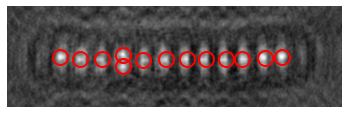

In [48]:
z0 = 37
b = bz[:, :, z0]
f = tp.locate(b, 13, minmass = 5.9, invert=False)
plt.imshow(b, cmap = 'gray')
plt.axis('off')
tp.annotate(f, b);

In [49]:
def make_unique(elements):
    return tuple(sorted(elements))

def remove_permutations(pairs):
    '''remove non-unique pairs from list of lists'''
    unique_pairs = set(map(make_unique, pairs))
    return [list(pair) for pair in unique_pairs]

def find_closest_npairs(x, y, n):
    '''find the closest n pairs based on Euclidean distance between particles'''
    n*=2
    distances = np.sqrt(np.square(x[:, np.newaxis] - x) + np.square(y[:, np.newaxis] - y))
    np.fill_diagonal(distances, np.inf)
    indices = np.argsort(distances.flatten())[:n]
    closest_pairs = np.column_stack(np.unravel_index(indices, distances.shape))
    return remove_permutations(closest_pairs)

def get_coords_choose_average(x, y, n):
    '''get coordinates of particles. In case trackpy locates m features for n particles, we may want to
    average features that are super close to each other to end up with n features'''
    list_of_closest_coords = find_closest_npairs(x, y, 1)
    indexlist = list(chain(*list_of_closest_coords))
    x_res = [x[i] for i in range(len(x)) if i not in indexlist]
    y_res = [y[i] for i in range(len(y)) if i not in indexlist]
    for pair in list_of_closest_coords:
        i, j = pair[0], pair[1]
        x_ave = (x[i]+x[j])*.5
        y_ave = (y[i]+y[j])*.5
        x_res.append(x_ave)
        y_res.append(y_ave)
    return x_res, y_res

def get_coords_choose_stronger(f, n):
    '''get coordinates of particles. In case trackpy locates m features for n particles, we find the closest pair and then
    choose the particle with bigger signal, leaving out the other. Keep doing so until we have n features left'''
    x = f.x.values
    y = f.y.values
    m = f.mass.values
    list_of_closest_coords = find_closest_npairs(x, y, 3) #only look at one pair for now
    indexlist = list(chain(*list_of_closest_coords))
    x_res = [x[i] for i in range(len(x)) if i not in indexlist]
    y_res = [y[i] for i in range(len(y)) if i not in indexlist]
    for pair in list_of_closest_coords:
        i, j = pair[0], pair[1]
        mass_i, mass_j = m[i], m[j]
        if mass_i > mass_j:
            x_res.append(x[i])
            y_res.append(y[i])
        else:
            x_res.append(x[j])
            y_res.append(y[j])
    return x_res, y_res

In [50]:
x_res, y_res = get_coords_choose_average(f.x.values, f.y.values, 12)

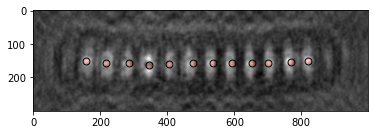

In [51]:
def sort_list_and_indices(lst):
    indices = range(len(lst))
    sorted_indices = sorted(indices, key=lambda x: lst[x])
    sorted_list = [lst[i] for i in sorted_indices]
    return sorted_list, sorted_indices

y_res, srt_indx = sort_list_and_indices(y_res)
x_res = [x_res[i] for i in srt_indx]
fig, ax = plt.subplots()
ax.imshow(b, cmap = 'gray')
ax.scatter(x_res, y_res, marker = 'o', s = 48, facecolor=colors.to_rgba('r', .2), edgecolor = 'k');

#### iterate through all monomers, performing rayleigh sommerfeld propagation at each (x,y) values and picking z that maximizes intensity

{0: [(46.59736436597111, 16.874006420545747, 17.3), (14.780499108295924, 16.888850624192855, 16.5), (44.08901593541594, 16.935208704808705, 16.5), (40.799544222375374, 17.090815529519872, 16.9), (32.9484070647603, 17.125959389643157, 16.5), (30.00108826465136, 17.140910879794667, 16.2), (20.823142219444694, 17.148144629943754, 16.6), (35.71057119585339, 17.179759792669383, 16.6), (38.51674186095358, 17.18156017643352, 16.7), (17.54370152831885, 17.182439316751573, 16.7), (26.63704947526237, 17.28958636471238, 16.6), (23.761794602766432, 17.350240704038498, 17.1)]}


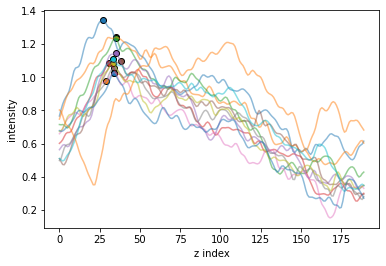

In [52]:
res = dict()
n = 200
num_monomers = 12 #chain length

frame0 = []
for i in range(num_monomers):
        
    #true (x,y) values based on 1280x1024 coordinate system. Values in microns
    x = (x_res[i]+xmin)*mpp
    y = (y_res[i]+ymin)*mpp
    
    #bz has shape (dy,dz,n)
    intensity_list = bz[int(y_res[i]), int(x_res[i]), :]
    phi_list = phi[int(y_res[i]), int(x_res[i]), :]
    
    smallz = 5
    #dIdz = np.diff(intensity_list, n=1)[smallz:n-smallz] #gradient of intensity
    I=intensity_list[smallz:n-smallz]
    plt.plot(I, alpha = .5)
    plt.xlabel('z index')
    plt.ylabel('intensity')
    
    zi = [i for i, x in enumerate(I) if x == max(I)][0] #find global peak
    if abs(zi-z0)>50: #particle can't have moved that much
        #dIdz = np.diff(intensity_list, n=1)[z0-15:z0+15]
        I=intensity_list[z0-15:z0+15]
        zi = [i for i, x in enumerate(I) if x == max(I)][0] #find local peak if global peak is
            #too far
    z = abs(zmin + (zi/n)*(zmax-zmin))
    plt.scatter([zi], [I[zi]], edgecolor = 'k')
    
    frame0.append((x,y,z))

res[0] = frame0
print(res)

./results/060922_n12_z600.pickle


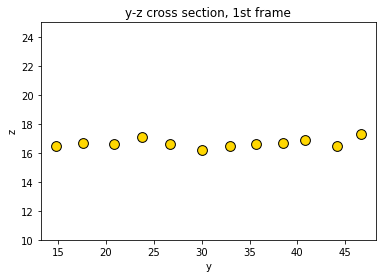

In [55]:
fig, ax = plt.subplots()
frame0 = res[0]
for coords in frame0:
    ax.scatter(coords[0], coords[2], facecolor = 'gold', edgecolor = 'k', s=96)
ax.set_title('y-z cross section, 1st frame')
ax.set_ylim([10,25])
ax.set_xlabel('y')
ax.set_ylabel('z');

#print out filename to make sure everything is kosher and we aren't overwriting
filename = './results/' + date + '_n{}'.format(num_monomers) + '_z{}'.format(h) 
print(filename + '.pickle')

#### save this dictionary to be used in rs_auto for other frames

In [56]:
with open(filename + '.pickle', 'wb') as handle:
    pickle.dump(res, handle)

In [57]:
with open(filename + '.pickle', 'rb') as handle:
    res = pickle.load(handle)
print(res.keys())

dict_keys([0])
